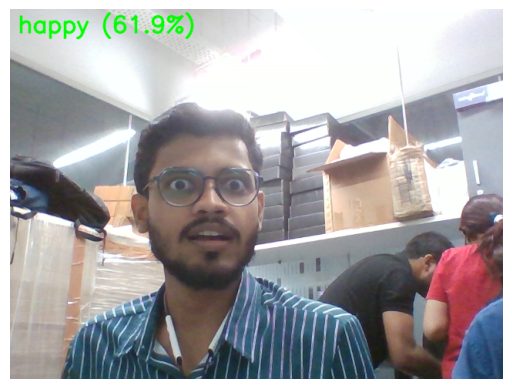

üòä Detected Emotion: neutral
[youtube] ZbZSe6N_BXs: Downloading tv client config
[youtube] ZbZSe6N_BXs: Downloading tv player API JSON
[youtube] ZbZSe6N_BXs: Downloading ios player API JSON
[youtube] ZbZSe6N_BXs: Downloading m3u8 information
üéµ Streaming from YouTube: https://www.youtube.com/watch?v=ZbZSe6N_BXs


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from IPython.display import display, clear_output
import yt_dlp
import vlc
import threading
import time
from collections import deque

# üß† Smoothing: last 5 predictions
pred_history = deque(maxlen=5)
current_emotion = None
music_player = None
music_thread = None

# üéµ Mapping emotions to YouTube URLs
emotion_music = {
    "angry": "https://www.youtube.com/watch?v=ZpDQJnI4OhU",       # Angry music
    "disgust": "https://www.youtube.com/watch?v=fLexgOxsZu0",     # Disgust ‚Üí uplifting
    "fear": "https://www.youtube.com/watch?v=2Vv-BfVoq4g",        # Fear ‚Üí calming
    "happy": "https://www.youtube.com/watch?v=ZbZSe6N_BXs",       # Happy ‚Üí Pharrell Happy
    "sad": "https://www.youtube.com/watch?v=ho9rZjlsyYY",         # Sad ‚Üí relaxing
    "surprise": "https://www.youtube.com/watch?v=d-diB65scQU",    # Surprise ‚Üí upbeat
    "neutral": "https://www.youtube.com/watch?v=5qap5aO4i9A"      # Neutral ‚Üí chill lofi
}


def play_youtube_music(youtube_url):
    """Play YouTube music using VLC."""
    global music_player
    try:
        # Get the direct audio stream URL using yt_dlp
        ydl_opts = {'format': 'bestaudio/best'}
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(youtube_url, download=False)
            audio_url = info['url']

        # Initialize VLC player
        print(f"üéµ Streaming from YouTube: {youtube_url}")
        music_player = vlc.MediaPlayer(audio_url)
        music_player.play()

        # Wait until music finishes
        while music_player.get_state() != vlc.State.Ended:
            time.sleep(1)

    except Exception as e:
        print(f"‚ùå Error playing YouTube audio: {e}")


# ‚úÖ Start webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("‚ùå Cannot open webcam")
else:
    print("‚úÖ Webcam started. Stop the cell or press Ctrl+C to exit.")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("‚ùå Failed to grab frame")
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        try:
            # Analyze face for emotions
            predictions = DeepFace.analyze(
                frame_rgb,
                actions=['emotion'],
                enforce_detection=False
            )[0]

            # ‚úÖ Get dominant emotion and confidence
            detected_emotion = predictions['dominant_emotion']
            confidence = predictions['emotion'][detected_emotion]

            # üß† Smooth predictions
            pred_history.append(detected_emotion)
            smoothed_emotion = max(set(pred_history), key=pred_history.count)

            label = f"{smoothed_emotion} ({confidence:.1f}%)"

            # üéµ Play music if emotion changes
            if smoothed_emotion != current_emotion:
                current_emotion = smoothed_emotion
                print(f"üòä Detected Emotion: {current_emotion}")

                # Stop previous music
                if music_player:
                    music_player.stop()

                # Start new music thread
                youtube_url = emotion_music.get(current_emotion)
                if youtube_url:
                    if music_thread and music_thread.is_alive():
                        music_thread.join()
                    music_thread = threading.Thread(target=play_youtube_music, args=(youtube_url,))
                    music_thread.start()

        except Exception as e:
            label = "No Face Detected"
            print(f"‚ö†Ô∏è Detection error: {e}")

        # Display result on frame
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2, cv2.LINE_AA)

        # Convert BGR to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display in Jupyter
        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.axis('off')
        display(plt.gcf())
        plt.clf()

except KeyboardInterrupt:
    print("üõë Streaming stopped by user.")

finally:
    cap.release()
    if music_player:
        music_player.stop()
    print("‚úÖ Webcam released.")
